In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import math

import pandas_datareader.data as web
import datetime as dt

## Data preprocessing

In [3]:
# step 1 load data
start = dt.datetime(2000,1,1)
end = dt.datetime(2017,3,1)

df = web.DataReader('GOOGL','yahoo',start,end)
df.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2004-08-19,99.999999,104.059999,95.959998,100.339998,44659000,50.220219
2004-08-20,101.010005,109.079998,100.500002,108.310002,22834300,54.209210
2004-08-23,110.750003,113.479998,109.049999,109.399998,18256100,54.754754
2004-08-24,111.239999,111.599998,103.570003,104.870002,15247300,52.487488
2004-08-25,104.960000,108.000002,103.880003,106.000005,9188600,53.053055


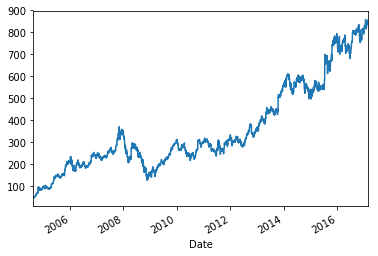

In [4]:
df['Adj Close'].plot()
plt.show()

In [5]:
# pick the final stock data
data = df['Adj Close'].values

In [6]:
# normalize the dataset
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
data_norm = scaler.fit_transform(data)

C:\Anaconda3\envs\DLNDF\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Anaconda3\envs\DLNDF\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [7]:
data_norm

array([  2.04312259e-04,   5.13877030e-03,   5.81361864e-03, ...,
         9.89138936e-01,   9.83275478e-01,   9.97897053e-01])

In [8]:
#split into train and test sets
train_size = int(len(data_norm) * 0.8)
test_size = len(data_norm) - train_size
train, test = data_norm[0:train_size], data_norm[train_size:len(data_norm)]
print(len(train), len(test))

2524 631


In [9]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [10]:
# reshape into X=t and Y=t+1
look_back = 30
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [11]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((2493, 30), (2493,), (600, 30), (600,))

In [12]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [13]:
trainX.shape, testX.shape

((2493, 30, 1), (600, 30, 1))

## Create LSTM MODEL

In [14]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM

Using TensorFlow backend.


In [15]:
model = Sequential()
model.add(LSTM(128, input_shape=(look_back,1), return_sequences=True))  # only 1 feature
model.add(Dropout(0.2))
model.add(LSTM(64,input_shape=(look_back,1), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(16, init='uniform',activation='relu'))
model.add(Dense(1, init='uniform',activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

In [16]:
#Step 3 Train the model
#model.fit(trainX, trainY, nb_epoch=10, batch_size=512, validation_split=0.05)
model.fit(trainX, trainY, nb_epoch=20, batch_size=510, validation_split = 0.1, verbose=1)

Train on 2243 samples, validate on 250 samples
Epoch 1/20
2243/2243 [==============================] - 6s - loss: 0.0682 - acc: 0.0000e+00 - val_loss: 0.3333 - val_acc: 0.0000e+00
Epoch 2/20
2243/2243 [==============================] - 4s - loss: 0.0482 - acc: 0.0000e+00 - val_loss: 0.2557 - val_acc: 0.0000e+00
Epoch 3/20
2243/2243 [==============================] - 4s - loss: 0.0212 - acc

In [17]:
import math
from sklearn.metrics import mean_squared_error

In [18]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
# calculate root mean squared error
#trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
#testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 100.70 RMSE
Test Score: 412.59 RMSE


C:\Anaconda3\envs\DLNDF\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Anaconda3\envs\DLNDF\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


C:\Anaconda3\envs\DLNDF\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


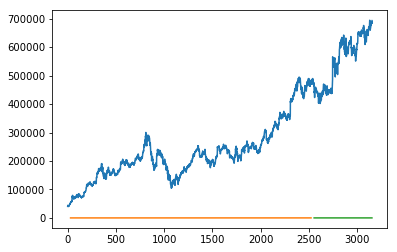

In [19]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict[:,0]
# shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1] = testPredict[:,0]
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [31]:
np.nan

nan

In [49]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

In [50]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    4,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

#start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
#print 'compilation time : ', time.time() - start

In [60]:
#Step 3 Train the model
model.fit(
    trainX,
    trainY,
    batch_size=512,
    nb_epoch=10,
    validation_split=0.05)

Train on 2003 samples, validate on 106 samples
Epoch 1/10
2003/2003 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0048
Epoch 2/10
2003/2003 [==============================] - 0s - loss: 0.0020 - val_loss: 0.0040
Epoch 3/10
2003/2003 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0034
Epoch 4/10
2003/2003 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0026

In [58]:
def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [59]:
#Step 4 - Plot the predictions!
predictions = predict_sequences_multiple(model, testX, 50, 50)
lstm.plot_results_multiple(predictions, y_test, 50)

NameError: name 'newaxis' is not defined

In [61]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

C:\Anaconda3\envs\DLNDF\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Anaconda3\envs\DLNDF\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


TypeError: Singleton array 52.487488000000006 cannot be considered a valid collection.